In [2]:
import sys
import logging


base_path = '/notebooks/eipi10/python-book/arsenal'
sys.path.append(base_path)
current_path = '.'
current_data_path = current_path + "/data"


logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)

import collections
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import time


from pprint import pprint
from eipi10.ml2.utils import *

pd.set_option('display.width', 1000)
os.environ["https_proxy"] = "http://web-proxy.rose.hp.com:8080"
os.environ["http_proxy"] = "http://web-proxy.rose.hp.com:8080"

%matplotlib inline

# 代码自动重新加载
%load_ext autoreload
%autoreload 2

#当module有新的方法的时候，需要运行下面方法。
# %reload_ext autoreload 



In [149]:
import numpy as np
import math

def rotate(theta):
  A = np.array([1/2, math.sqrt(3)/2])


a = 
[[ 1  0  2]
 [-1  3  1]]

b = 
[[3 1]
 [2 1]
 [1 0]]

c = 
[[5 1]
 [4 2]]



### 1.52 WMD(Word Mover's Distance)

摘自[Finding similar documents with Word2Vec and WMD](https://markroxor.github.io/gensim/static/notebooks/WMD_tutorial.html)

#### Part 1: Computing the Word Mover's Distance

使用WMD之前，我们需要 word embeddings。

In [14]:
# !pip install  nltk
!pip install pyemd 

    100% |################################| 92kB 345kB/s ta 0:00:011
  Running setup.py bdist_wheel for pyemd ... done
  Stored in directory: /root/.cache/pip/wheels/e4/ba/b0/1f4178a35c916b22fc51dc56f278125d4b8cfb0592e5f0cc24
Successfully built pyemd
You are using pip version 18.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
from time import time
start_nb = time()

In [22]:
# Initialize logging.
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')

sentence_obama = 'Obama speaks to the media in Illinois'
sentence_president = 'The president greets the press in Chicago'
sentence_other = 'you have a large vocabulary and/or large vectors'
sentence_obama = sentence_obama.lower().split()
sentence_president = sentence_president.lower().split()
sentence_other = sentence_other.lower().split()

In [23]:
# Import and download stopwords from NLTK.
from nltk.corpus import stopwords
from nltk import download
download('stopwords')  # Download stopwords list.

# Remove stopwords.
stop_words = stopwords.words('english')
sentence_obama = [w for w in sentence_obama if w not in stop_words]
sentence_president = [w for w in sentence_president if w not in stop_words]
sentence_other = [w for w in sentence_other if w not in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
start = time()
import os

from gensim.models import KeyedVectors
if not os.path.exists('data/w2v_googlenews/GoogleNews-vectors-negative300.bin.gz'):
    raise ValueError("SKIP: You need to download the google news model")
    
model = KeyedVectors.load_word2vec_format('data/w2v_googlenews/GoogleNews-vectors-negative300.bin.gz', binary=True)
print('Cell took %.2f seconds to run.' % (time() - start))

Cell took 272.66 seconds to run.


In [15]:
distance = model.wmdistance(sentence_obama, sentence_president)
print('distance = %.4f' % distance)

distance = 3.3741


In [16]:
sentence_orange = 'Oranges are my favorite fruit'
sentence_orange = sentence_orange.lower().split()
sentence_orange = [w for w in sentence_orange if w not in stop_words]

distance = model.wmdistance(sentence_obama, sentence_orange)
print('distance = %.4f' % distance)

distance = 4.3802


##### Normalizing word2vec vectors

使用wmdistance时，最好能够先normalize the word2vec vector. 

In [18]:
# Normalizing word2vec vectors.
start = time()

model.init_sims(replace=True)  # Normalizes the vectors in the word2vec class.
print('Cell took %.2f seconds to run.' %(time() - start))

Cell took 3.78 seconds to run.


In [25]:

distance = model.wmdistance(sentence_obama, sentence_president)  # Compute WMD as normal.
print('distance = %.4f' % distance)
distance = model.wmdistance(sentence_obama, sentence_orange)
print('distance = %.4f' % distance)
distance = model.wmdistance(sentence_obama, sentence_other)
print('distance = %.4f' % distance)
distance = model.wmdistance(sentence_orange, sentence_other)
print('distance = %.4f' % distance)

distance = 1.0175
distance = 1.3663
distance = 1.3237
distance = 1.3388


#### Part 2: Similarity queries using WmdSimilarity

使用WmdSimilarity class, 可以使用WMD得到最相似的文档

##### Yelp data

下载六家餐馆来训练Word2Vec embeddings

- Mon Ami Gabi.
- Earl of Sandwich.
- Wicked Spoon.
- Serendipity 3.
- Bacchanal Buffet.
- The Buffet.

In [26]:
# Pre-processing a document.

from nltk import word_tokenize
download('punkt')  # Download data for tokenizer.

def preprocess(doc):
    doc = doc.lower()  # Lower the text.
    doc = word_tokenize(doc)  # Split into words.
    doc = [w for w in doc if not w in stop_words]  # Remove stopwords.
    doc = [w for w in doc if w.isalpha()]  # Remove numbers and punctuation.
    return doc

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [36]:
start = time()

import json

# Business IDs of the restaurants.
ids = ['4bEjOyTaDG24SY5TxsaUNQ', '2e2e7WgqU1BnpxmQL5jbfw', 'zt1TpTuJ6y9n551sw9TaEg',
      'Xhg93cMdemu5pAMkDoEdtQ', 'sIyHTizqAiGu12XMLX3N3g', 'YNQgak-ZLtYJQxlDwN-qIg']
ids = ['ZRJwVLyzEJq1VAihDhYiow']

w2v_corpus = []  # Documents to train word2vec on (all 6 restaurants).
wmd_corpus = []  # Documents to run queries against (only one restaurant).
documents = []  # wmd_corpus, with no pre-processing (so we can see the original documents).
max_line = 10000
i = 0
with open('data/yelp_dataset/yelp_academic_dataset_review.json') as data_file:
    for line in data_file:
        i = i+1        
        if i >= max_line: continue
            
        json_line = json.loads(line)
        
#         if json_line['business_id'] not in ids:
#             # Not one of the 6 restaurants.
#             continue
        
        # Pre-process document.
        text = json_line['text']  # Extract text from JSON object.
        text = preprocess(text)
        
        # Add to corpus for training Word2Vec.
        w2v_corpus.append(text)
        
        if json_line['business_id'] == ids[0]:
            # Add to corpus for similarity queries.
            wmd_corpus.append(text)
            documents.append(json_line['text'])

print('Cell took %.2f seconds to run.' %(time() - start))
print(len(w2v_corpus))
print(len(wmd_corpus))
print(len(documents))

Cell took 24.06 seconds to run.
9999
6
6


计算一下文档的平均长度。

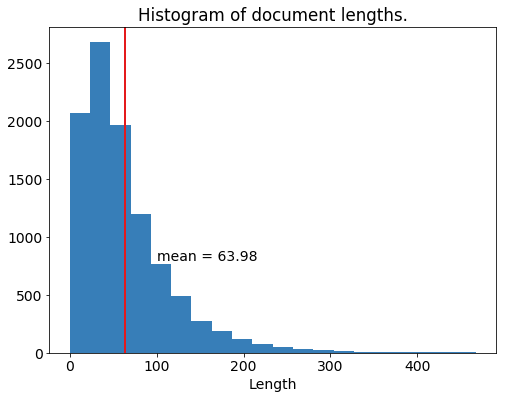

In [44]:
from matplotlib import pyplot as plt
from cycler import cycler
%matplotlib inline

# Document lengths.
lens = [len(doc) for doc in w2v_corpus]

# Plot.
plt.rc('figure', figsize=(8,6))
plt.rc('font', size=14)
plt.rc('lines', linewidth=2)
# plt.rc('axes', color_cycle=('#377eb8','#e41a1c','#4daf4a',
#                             '#984ea3','#ff7f00','#ffff33'))
plt.rc('axes', prop_cycle=(cycler('color', ['#377eb8','#e41a1c','#4daf4a',
                                           '#984ea3','#ff7f00','#ffff33'])))
# Histogram.
plt.hist(lens, bins=20)
# plt.hold(True)
# Average length.
avg_len = sum(lens) / float(len(lens))
plt.axvline(avg_len, color='#e41a1c')
# plt.hold(False)
plt.title('Histogram of document lengths.')
plt.xlabel('Length')
plt.text(100, 800, 'mean = %.2f' % avg_len)
plt.show()

训练word2vec模型

In [51]:
# Train Word2Vec on all the restaurants.
model = Word2Vec(w2v_corpus, workers=5, size=100)

# Initialize WmdSimilarity.
from gensim.similarities import WmdSimilarity
num_best = 5
instance = WmdSimilarity(wmd_corpus, model, num_best=num_best)

In [52]:
start = time()

sent = 'Very good, you should seat outdoor.'
query = preprocess(sent)

sims = instance[query]  # A query is simply a "look-up" in the similarity class.

print('Cell took %.2f seconds to run.' %(time() - start))

Cell took 0.04 seconds to run.


In [54]:
print('Query:')
print(sent)
# Print the query and the retrieved documents, together with their similarities.
for i in range(num_best):
    print('sim = %.4f' % sims[i][1])
    print(documents[sims[i][0]])

Query:
Very good, you should seat outdoor.
sim = 0.5383
Spinato's has great red sauce for the pasta but I prefer a more earthy pizza. High School kids love it though. 
This restaurant was a Chili's before, but they have remodeled and did a fabulous job. The take out door is discrete and the bar area is large and comfortable. 
Food portions are quite big and they have a nice selection on the menu.
sim = 0.5307
I have no idea why some people give bad reviews about this place. It goes to show you, you can please everyone. They are probably griping about something that their own fault...there are many people like that.

In any case, my friend and I arrived at about 5:50 PM this past Sunday. It was pretty crowded, more than I thought for a Sunday evening and thought we would have to wait forever to get a seat but they said we'll be seated when the girl comes back from seating someone else. We were seated at 5:52 and the waiter came and got our drink orders. Everyone was very pleasant from t

In [56]:
start = time()

sent = 'I felt that the prices were extremely reasonable for the Strip'
query = preprocess(sent)

sims = instance[query]  # A query is simply a "look-up" in the similarity class.

print('Query:')
print(sent)
for i in range(num_best):
    print()
    print('sim = %.4f' % sims[i][1])
    print(documents[sims[i][0]])

print('\nCell took %.2f seconds to run.' %(time() - start))

Query:
I felt that the prices were extremely reasonable for the Strip

sim = 0.5479
Spinato's has great red sauce for the pasta but I prefer a more earthy pizza. High School kids love it though. 
This restaurant was a Chili's before, but they have remodeled and did a fabulous job. The take out door is discrete and the bar area is large and comfortable. 
Food portions are quite big and they have a nice selection on the menu.

sim = 0.5391
Great Pizza. Great Service.

We've been here a few times since it opened. And always look forward to going. We have never had a bad experience. Each time has been great. Our waiter Dave was perfect, always on the ball.

sim = 0.5225
Great customer service, perfect dining area! This lightly dimmed pizzeria is nothing like the other high top table pizza places, the staff and waitress' are really friendly with along great customer service! (and I am picky with people who serve at restaurants!) this place is great for family or even with friends to get a g

### 1.51 gensim LDA 模型 

https://nbviewer.jupyter.org/github/dsquareindia/gensim/blob/a4b2629c0fdb0a7932db24dfcf06699c928d112f/docs/notebooks/topic_coherence_tutorial.ipynb

In [60]:
# !pip install pyldavis

In [61]:
import numpy as np
import logging
import pyLDAvis.gensim
import json
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

texts = [['human', 'interface', 'computer'],
         ['survey', 'user', 'computer', 'system', 'response', 'time'],
         ['eps', 'user', 'interface', 'system'],
         ['system', 'human', 'system', 'eps'],
         ['user', 'response', 'time'],
         ['trees'],
         ['graph', 'trees'],
         ['graph', 'minors', 'trees'],
         ['graph', 'minors', 'survey']]

dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [62]:
goodLdaModel = LdaModel(corpus=corpus, id2word=dictionary, iterations=50, num_topics=2)
badLdaModel = LdaModel(corpus=corpus, id2word=dictionary, iterations=1, num_topics=2)

2019-10-12 07:13:21,096 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-10-12 07:13:21,134 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy


In [68]:
goodcm = CoherenceModel(model=goodLdaModel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
badcm = CoherenceModel(model=badLdaModel, corpus=corpus, dictionary=dictionary, coherence='u_mass')

In [69]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(goodLdaModel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x    y
topic                                           
0      65.826027        1       1  0.048649  0.0
1      34.173973        1       2 -0.048649  0.0, topic_info=     Category      Freq       Term     Total  loglift  logprob
term                                                          
9     Default  2.000000      trees  2.000000  12.0000  12.0000
10    Default  2.000000      graph  2.000000  11.0000  11.0000
6     Default  1.000000     minors  1.000000  10.0000  10.0000
11    Default  3.000000     system  3.000000   9.0000   9.0000
2     Default  2.000000     survey  2.000000   8.0000   8.0000
4     Default  2.000000       time  2.000000   7.0000   7.0000
0     Default  2.000000   response  2.000000   6.0000   6.0000
7     Default  2.000000      human  2.000000   5.0000   5.0000
3     Default  2.000000        eps  2.000000   4.0000   4.0000
1     Default  2.000000  interface  2.000000   3.0000   3.0000
5     Default  2.000000   computer  2.000000   2.0000   2.0000
8     Default  2.000000       user  2.000000   1.0000   1.0000
11     Topic1  3.405770     system  3.850255   0.2955  -1.7237
3      Topic1  1.881840        eps  2.263116   0.2337  -2.3169
8      Topic1  2.428690       user  2.994080   0.2089  -2.0618
5      Topic1  1.628015   computer  2.189245   0.1220  -2.4618
1      Topic1  1.622879  interface  2.187749   0.1195  -2.4649
7      Topic1  1.521961      human  2.158379   0.0688  -2.5291
0      Topic1  1.518653   response  2.157415   0.0671  -2.5313
4      Topic1  1.469496       time  2.143109   0.0408  -2.5642
2      Topic1  1.378037     survey  2.116492  -0.0109  -2.6285
6      Topic1  0.685416     minors  1.914915  -0.6092  -3.3269
10     Topic1  0.842132      graph  2.532336  -0.6828  -3.1210
9      Topic1  0.706658      trees  2.492908  -0.8425  -3.2963
9      Topic2  1.786250      trees  2.492908   0.7404  -1.7135
10     Topic2  1.690204      graph  2.532336   0.6694  -1.7687
6      Topic2  1.229500     minors  1.914915   0.6306  -2.0870
2      Topic2  0.738455     survey  2.116492   0.0208  -2.5968
4      Topic2  0.673613       time  2.143109  -0.0837  -2.6887
0      Topic2  0.638763   response  2.157415  -0.1434  -2.7418
7      Topic2  0.636417      human  2.158379  -0.1476  -2.7455
1      Topic2  0.564870  interface  2.187749  -0.2803  -2.8647
5      Topic2  0.561229   computer  2.189245  -0.2875  -2.8712
8      Topic2  0.565389       user  2.994080  -0.5932  -2.8638
3      Topic2  0.381276        eps  2.263116  -0.7073  -3.2578
11     Topic2  0.444485     system  3.850255  -1.0853  -3.1044, token_table=      Topic      Freq       Term
term                            
5         1  0.913557   computer
5         2  0.456779   computer
3         1  0.883737        eps
10        1  0.394892      graph
10        2  0.789785      graph
7         1  0.926621      human
7         2  0.463311      human
1         1  0.914181  interface
1         2  0.457091  interface
6         1  0.522216     minors
6         2  0.522216     minors
0         1  0.927035   response
0         2  0.463518   response
2         1  0.472480     survey
2         2  0.472480     survey
11        1  0.779169     system
4         1  0.466612       time
4         2  0.466612       time
9         1  0.401138      trees
9         2  0.802276      trees
8         1  0.667985       user
8         2  0.333992       user, R=12, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [70]:
pyLDAvis.gensim.prepare(badLdaModel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x    y
topic                                           
0      51.554352        1       1  0.001744  0.0
1      48.445648        1       2 -0.001744  0.0, topic_info=     Category      Freq       Term     Total  loglift  logprob
term                                                          
2     Default  2.000000     survey  2.000000  12.0000  12.0000
6     Default  2.000000     minors  2.000000  11.0000  11.0000
1     Default  2.000000  interface  2.000000  10.0000  10.0000
10    Default  2.000000      graph  2.000000   9.0000   9.0000
11    Default  3.000000     system  3.000000   8.0000   8.0000
0     Default  2.000000   response  2.000000   7.0000   7.0000
3     Default  2.000000        eps  2.000000   6.0000   6.0000
5     Default  2.000000   computer  2.000000   5.0000   5.0000
7     Default  2.000000      human  2.000000   4.0000   4.0000
8     Default  2.000000       user  2.000000   3.0000   3.0000
9     Default  2.000000      trees  2.000000   2.0000   2.0000
4     Default  2.000000       time  2.000000   1.0000   1.0000
1      Topic1  1.270181  interface  2.136203   0.1427  -2.4656
11     Topic1  2.037159     system  3.553880   0.1060  -1.9932
8      Topic1  1.539841       user  2.835837   0.0519  -2.2731
9      Topic1  1.496164      trees  2.832304   0.0243  -2.3019
4      Topic1  1.121681       time  2.124194   0.0240  -2.5899
7      Topic1  1.080940      human  2.120899  -0.0115  -2.6269
5      Topic1  1.051166   computer  2.118491  -0.0383  -2.6549
3      Topic1  1.040975        eps  2.117668  -0.0476  -2.6646
0      Topic1  1.040591   response  2.117636  -0.0480  -2.6650
10     Topic1  1.342170      graph  2.819852  -0.0799  -2.4105
6      Topic1  0.967584     minors  2.111732  -0.1179  -2.7377
2      Topic1  0.962310     survey  2.111305  -0.1232  -2.7432
2      Topic2  1.148996     survey  2.111305   0.1163  -2.5037
6      Topic2  1.144147     minors  2.111732   0.1119  -2.5079
10     Topic2  1.477681      graph  2.819852   0.0785  -2.2521
0      Topic2  1.077046   response  2.117636   0.0486  -2.5683
3      Topic2  1.076692        eps  2.117668   0.0483  -2.5687
5      Topic2  1.067325   computer  2.118491   0.0392  -2.5774
7      Topic2  1.039959      human  2.120899   0.0121  -2.6034
4      Topic2  1.002512       time  2.124194  -0.0262  -2.6401
9      Topic2  1.336140      trees  2.832304  -0.0266  -2.3528
8      Topic2  1.295996       user  2.835837  -0.0583  -2.3833
11     Topic2  1.516721     system  3.553880  -0.1268  -2.2260
1      Topic2  0.866022  interface  2.136203  -0.1781  -2.7864, token_table=      Topic      Freq       Term
term                            
5         1  0.472034   computer
5         2  0.472034   computer
3         1  0.472218        eps
3         2  0.472218        eps
10        1  0.354629      graph
10        2  0.354629      graph
7         1  0.471498      human
7         2  0.471498      human
1         1  0.468120  interface
1         2  0.468120  interface
6         1  0.473545     minors
6         2  0.473545     minors
0         1  0.472225   response
0         2  0.472225   response
2         1  0.473641     survey
2         2  0.473641     survey
11        1  0.562765     system
11        2  0.562765     system
4         1  0.470767       time
4         2  0.470767       time
9         1  0.353069      trees
9         2  0.353069      trees
8         1  0.705259       user
8         2  0.352630       user, R=12, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [72]:
print(goodcm.get_coherence())
print(badcm.get_coherence())

-14.646196768861003
-14.726061108336854


In [64]:
#  给定一个新文档，输出其主题分布'
def print_doc_topic(doc):
    print('-'*100)
    print(doc)
    print('-'*100)
    doc_bow = dictionary.doc2bow(doc)      #文档转换成bow
    doc_lda = lda[doc_bow]                   #得到新文档的主题分布
    #输出新文档的主题分布
    print(doc_lda)
    print('-'*100)
    for topic in doc_lda:
        print("%s\t%f\n"%(lda.print_topic(topic[0]), topic[1]))
        
print_doc_topic(train[6])      
print_doc_topic(train[21]) 

NameError: name 'train' is not defined

### 1.50 分词效果

In [35]:
chat='''请问一下win10系统怎么连上3055的网卡功能？ 我想使用它的无线打印 
亲 打印机上是网线连接还是无线呢
无线
亲只查询到有网线和USB功能
不会啊，我们公司的人用的是无线的啊
亲打印机上有无线灯吗
只是现在他们不会设置了，所以我来问问您 
'''

sent='''请您尽快联系服务站，请使用蓝色的手柄，天空是黑色的'''

#### Jieba

jieba的词性分类如下
- [hscspring/结巴词性标记集](https://gist.github.com/hscspring/c985355e0814f01437eaf8fd55fd7998) : 这个更加符合jieba
- [中文分词词性对照表](https://blog.csdn.net/kevin_darkelf/article/details/39520881)： 这个符合其他的

In [36]:
import jieba.posseg                                                            
 
word_tags = jieba.posseg.cut(sent)                             
print(' '.join('%s/%s' % (word, tag) for (word, tag) in word_tags if word.strip())) 


# for word, tag in word_tags:
#     print('-'*50)
#     word_tags_1 = [(word, tag) for word, tag in jieba.posseg.cut(word) ]
#     print(word_tags_1)
#     print('{}:{}'.format(word, tag))


请/v 您/r 尽快/d 联系/n 服务站/n ，/x 请/v 使用/v 蓝色/n 的/uj 手柄/n ，/x 天空/n 是/v 黑色/n 的/uj


#### SnowNLP

https://github.com/isnowfy/snownlp

SnowNLP是一个python写的类库，可以方便的处理中文文本内容，是受到了TextBlob的启发而写的，由于现在大部分的自然语言处理库基本都是针对英文的，于是写了一个方便处理中文的类库，并且和TextBlob不同的是，这里没有用NLTK，所有的算法都是自己实现的，并且自带了一些训练好的字典。

In [37]:
# !pip install --upgrade snownlp --proxy http://web-proxy.rose.hp.com:8080 

In [38]:
from snownlp import SnowNLP   
snow_result = SnowNLP(sent)  
print(' '.join('%s/%s' % (word, tag) for (word, tag) in snow_result.tags))

请/v 您/r 尽快/d 联系/v 服务站/n ，/w 请/v 使用/v 蓝色/n 的/u 手柄/n ，/w 天空/n 是/v 黑色/n 的/u


#### PkuSeg

https://github.com/lancopku/pkuseg-python

一个多领域中文分词工具包。kuseg具有如下几个特点：

- 多领域分词。不同于以往的通用中文分词工具，此工具包同时致力于为不同领域的数据提供个性化的预训练模型。根据待分词文本的领域特点，用户可以自由地选择不同的模型。 我们目前支持了新闻领域，网络领域，医药领域，旅游领域，以及混合领域的分词预训练模型。在使用中，如果用户明确待分词的领域，可加载对应的模型进行分词。如果用户无法确定具体领域，推荐使用在混合领域上训练的通用模型。各领域分词样例可参考 example.txt。
- 更高的分词准确率。相比于其他的分词工具包，当使用相同的训练数据和测试数据，pkuseg可以取得更高的分词准确率。
- 支持用户自训练模型。支持用户使用全新的标注数据进行训练。
- 支持词性标注。

In [39]:
# !pip install --upgrade pkuseg --proxy http://web-proxy.rose.hp.com:8080 

In [40]:
import pkuseg    
pku_seg = pkuseg.pkuseg(postag=True) 
pku_results = pku_seg.cut(sent) 
# print(pku_results)
print(' '.join('%s/%s' % (word, tag) for (word, tag) in pku_results))  

请/v 您/r 尽快/d 联系/v 服务站/n ，/w 请/v 使用/v 蓝色/n 的/u 手柄/n ，/w 天空/n 是/v 黑色/n 的/u


#### THULAC

https://github.com/thunlp/THULAC-Python
    
THULAC（THU Lexical Analyzer for Chinese）由清华大学自然语言处理与社会人文计算实验室研制推出的一套中文词法分析工具包，具有中文分词和词性标注功能。THULAC具有如下几个特点：

- 能力强。利用我们集成的目前世界上规模最大的人工分词和词性标注中文语料库（约含5800万字）训练而成，模型标注能力强大。
- 准确率高。该工具包在标准数据集Chinese Treebank（CTB5）上分词的F1值可达97.3％，词性标注的F1值可达到92.9％，与该数据集上最好方法效果相当。
- 速度较快。同时进行分词和词性标注速度为300KB/s，每秒可处理约15万字。只进行分词速度可达到1.3MB/s。

In [23]:
# !pip install --upgrade thulac --proxy http://web-proxy.rose.hp.com:8080 

    100% |################################| 52.9MB 1.3MB/s eta 0:00:01   16% |#####                           | 8.8MB 1.3MB/s eta 0:00:36    33% |##########                      | 17.9MB 35.1MB/s eta 0:00:01    37% |###########                     | 19.8MB 21.0MB/s eta 0:00:02    72% |#######################         | 38.6MB 2.7MB/s eta 0:00:06    84% |###########################     | 44.7MB 3.8MB/s eta 0:00:03    87% |###########################     | 46.2MB 34.9MB/s eta 0:00:01    92% |#############################   | 48.9MB 34.0MB/s eta 0:00:01    97% |############################### | 51.8MB 32.3MB/s eta 0:00:01
  Running setup.py bdist_wheel for thulac ... done
  Stored in directory: /root/.cache/pip/wheels/d2/3c/d4/2af73c09df43b30a03c280c85c5858b2744edf5d62edb5457b
Successfully built thulac
You are using pip version 18.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [30]:
import thulac 

thup = thulac.thulac() 
thulac_result = thup.cut(sent)
print(thulac_result)

print(' '.join('%s/%s' % (word, tag) for (word, tag) in thulac_result))

Model loaded succeed
[['请', 'v'], ['您', 'r'], ['尽快', 'd'], ['联系', 'v'], ['服务站', 'n'], ['，', 'w'], ['请', 'v'], ['使用', 'v'], ['蓝色', 'n'], ['的', 'u'], ['手柄', 'n']]
请/v 您/r 尽快/d 联系/v 服务站/n ，/w 请/v 使用/v 蓝色/n 的/u 手柄/n


In [29]:
thup = thulac.thulac(seg_only=True) 
thulac_result = thup.cut('我爱自然语言处理')
print(thulac_result)

thulac_result = thup.cut('我可以获得这个奖励吗')
print(thulac_result)

thup = thulac.thulac(seg_only=True, filt=True) 
thulac_result = thup.cut('我爱自然语言处理')
print(thulac_result)

thulac_result = thup.cut('我可以获得这个奖励吗')
print(thulac_result)

Model loaded succeed
[['我', ''], ['爱', ''], ['自然', ''], ['语言', ''], ['处理', '']]
[['我', ''], ['可以', ''], ['获得', ''], ['这个', ''], ['奖励', ''], ['吗', '']]
Model loaded succeed
[['我', ''], ['爱', ''], ['自然', ''], ['语言', ''], ['处理', '']]
[['我', ''], ['获得', ''], ['奖励', ''], ['吗', '']]


下面用聊天记录里面一段话来做分词测试，感觉总体来看jieba还是最好的。

In [15]:
word_tags = jieba.posseg.cut(chat)   
snow_result = SnowNLP(chat)  
pku_results = pku_seg.cut(chat) 
thulac_result = thup.cut(chat)

print('\n'.join('%s/%s' % (word, tag) for (word, tag) in word_tags if word.strip())) 
print('-'*50)
print('\n'.join('%s/%s' % (word, tag) for (word, tag) in snow_result.tags)) 
print('-'*50)
print('\n'.join('%s/%s' % (word, tag) for (word, tag) in pku_results)) 
print('-'*50)
print('\n'.join('%s/%s' % (word, tag) for (word, tag) in thulac_result)) 
print('-'*50)

请问/v
一下/m
win10/eng
系统/n
怎么/r
连上/d
3055/m
的/uj
网卡/n
功能/n
？/x
我/r
想/v
使用/v
它/r
的/uj
无线/n
打印/v
亲/v
打印机/n
上/f
是/v
网线/n
连接/v
还是/c
无线/n
呢/y
无线/n
亲/v
只/d
查询/v
到/v
有/v
网线/n
和/c
USB/eng
功能/n
不会/v
啊/zg
，/x
我们/r
公司/n
的/uj
人用/n
的/uj
是/v
无线/n
的/uj
啊/y
亲/v
打印机/n
上/f
有/v
无线/n
灯/n
吗/y
只是/c
现在/t
他们/r
不会/v
设置/vn
了/ul
，/x
所以/c
我/r
来/v
问问/n
您/zg
--------------------------------------------------
请问/v
一下/m
win10/q
系统/n
怎么/r
连/n
上/f
3055/o
的/u
网卡/s
功能/n
？/w
我/r
想/v
使用/v
它/r
的/u
无线/b
打印/vn
亲/a
打印机/n
上/f
是/v
网线/n
连接/v
还是/d
无线/b
呢/y
无线/b
亲/ad
只/d
查询/v
到有/Bg
网线/n
和/c
USB/h
功能/n
不/d
会/v
啊/y
，/w
我们/r
公司/n
的/u
人/n
用/v
的/u
是/v
无线/b
的/u
啊/y
亲/a
打印机/n
上/f
有/v
无线/b
灯/n
吗/y
只是/c
现在/t
他们/r
不/d
会/v
设置/v
了/y
，/w
所以/c
我/r
来/v
问问/v
您/r
--------------------------------------------------
请问/v
一下/m
win10/n
系统/n
怎么/r
连/v
上/v
3055/m
的/u
网卡/n
功能/n
？/w
我/r
想/v
使用/v
它/r
的/u
无线/b
打印/vn
亲/n
打印机/n
上/v
是/v
网线/n
连接/v
还是/c
无线/b
呢/y
无线/b
亲/n
只/d
查询/v
到/v
有/v
网线/n
和/c
USB/vn
功能/n
不/d
会/v
啊/y
，/w
我们/r
公司/n
的/u
人/n
用/v
的/u
是/v
无线/b
的/u
啊/y


### 1.49 Poision分布实例
某个小店，每天平均卖出5杯酸奶，老板希望90%的情况下，不会缺货，请问每天应该保持备货多少？

In [17]:
import scipy.stats as st
rv = st.poisson(5)
[(i, rv.pmf(i), rv.cdf(i)) for i in range(10)]
# pmf: probability mass function，概率质量函数
# cdf：cumulative distribution function，累积分布函数 
# 可以看出，当备货8个的时候，93.2%的情况下不会缺货，满足条件

[(0, 0.006737946999085467, 0.006737946999085468),
 (1, 0.03368973499542734, 0.04042768199451279),
 (2, 0.08422433748856832, 0.12465201948308108),
 (3, 0.1403738958142805, 0.2650259152973616),
 (4, 0.17546736976785063, 0.44049328506521257),
 (5, 0.17546736976785068, 0.615960654833063),
 (6, 0.1462228081398754, 0.7621834629729387),
 (7, 0.10444486295705395, 0.8666283259299925),
 (8, 0.06527803934815865, 0.9319063652781516),
 (9, 0.036265577415643714, 0.9681719426937951)]

可视化

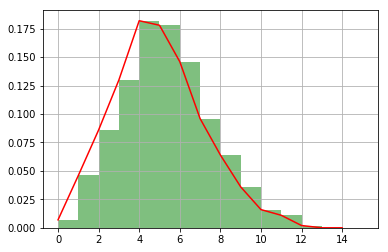

In [13]:
import numpy as np
import matplotlib.pyplot as plt

x = np.random.poisson(lam=5, size=1000)  # lam为λ size为k
pillar = 15
a = plt.hist(x, bins=pillar, normed=True, range=[0, pillar], color='g', alpha=0.5)
plt.plot(a[1][0:pillar], a[0], 'r')
plt.grid()
plt.show()


### 1.48 字符串编辑距离

参考
- [字符串编辑距离问题详解](https://www.cnblogs.com/jiabei521/p/3353390.html)


字符串的编辑距离也被称为距Levenshtein距离（Levenshtein Distance），属于经典算法，常用方法使用递归，更好的方法是使用动态规划算法，以避免出现重叠子问题的反复计算，减少系统开销。

函数dist(str1, str2)表示字串str1转变到字串str2的编辑距离，对于下面3种极端情况，容易给出解答（0表示空串）

- dist(0, 0) = 0
- dist(0, s) = strlen(s)
- dist(s, 0) = strlen(s)


对于一般的情况，dist(str1, str2)我们应该如何求解呢？


**解析：**

首先定义这样一个函数——edit(i, j)，它表示第一个字符串的长度为i的子串到第二个字符串的长度为j的子串的编辑距离。

显然可以有如下动态规划公式：

- if i == 0 且 j == 0, edit(i, j) = 0  
- if i == 0 且 j > 0, edit(i, j) = j  
- if i > 0 且j == 0, edit(i, j) = i  
- if i ≥ 1  且 j ≥ 1, edit(i, j) == min{ edit(i-1, j) + 1, edit(i, j-1) + 1, edit(i-1, j-1) + f(i, j)}     
  当第一个字符串的第i个字符不等于第二个字符串的第j个字符时，f(i, j) = 1；否则，f(i, j) = 0。 




In [65]:
def eidt_1(s1, s2):
    # 矩阵的下标得多一个
    len_str1 = len(s1) + 1
    len_str2 = len(s2) + 1
 
    # 初始化了一半  剩下一半在下面初始化
    matrix = [[0] * (len_str2) for i in range(len_str1)]
 
    for i in range(len_str1):
        for j in range(len_str2):
            if i == 0 and j == 0:
                matrix[i][j] = 0
            # 初始化矩阵
            elif i == 0 and j > 0:
                matrix[0][j] = j
            elif i > 0 and j == 0:
                matrix[i][0] = i
            # flag
            elif s1[i - 1] == s2[j - 1]:
                matrix[i][j] = min(matrix[i - 1][j - 1], matrix[i][j - 1] + 1, matrix[i - 1][j] + 1)
            else:
                matrix[i][j] = min(matrix[i - 1][j - 1] + 1, matrix[i][j - 1] + 1, matrix[i - 1][j] + 1)
    return matrix[len_str1 - 1][len_str2 - 1]


print(eidt_1('xymichael', 'michoelab'))
print(eidt_1('babab', 'ababa')) #

5
2


In [60]:
# ! pip install python-Levenshtein --proxy http://web-proxy.rose.hp.com:8080  

import Levenshtein
Levenshtein.distance('xymichael', 'michoelab')

5

### 1.47 熵的手工计算

In [73]:
from math import log, exp
import numpy as np

# 熵
def entropy(X, base=None):    
    h = sum([-x*log(x) for x in X]) if base is None else sum([-x*log(x, base) for x in X])
    return h

print('-'*50)
print(entropy([1/3, 2/3], base=2))    
print(entropy([1/2, 1/2], base=2))
frequency = [12.7, 9.1, 8.2, 7.5, 6.7, 7.0, 6.3, 6.1, 6.0, 4.3, 4.0, 
             2.8, 2.8, 2.4, 2.4, 2.2, 2.0, 2.0, 1.9, 1.5, 1.0, 0.2,
             0.8, 0.1, 0.2, 0.1]
frequency = [freq/100 for freq in frequency ]
print(sum(frequency), entropy(frequency))

# 联合熵
def joint_entropy(XY, base=None):
    xy = [p for xY in XY for p in xY ]
    return entropy(xy, base)
  
print('-'*50)    
XY = [[5/12,3/12], [1/12,3/12]]
print(joint_entropy(XY, base=2)) 

X = np.sum(np.array(XY), axis=0)
Y = np.sum(np.array(XY), axis=1)

# 可以发现，当X，Y并不独立的时候，整体X， Y的熵会变小。
print(X, Y, entropy(X, base=2), entropy(Y, base=2), entropy(X, base=2)+entropy(Y, base=2))

print('-'*50)    
XY = [[1/6,1/6], [1/6,3/6]]
print(joint_entropy(XY, base=2)) 

X = np.sum(np.array(XY), axis=0)
Y = np.sum(np.array(XY), axis=1)

# 可以发现，当X，Y并不独立的时候，整体X， Y的熵会变小。
print(X, Y, entropy(X, base=2), entropy(Y, base=2), entropy(X, base=2)+entropy(Y, base=2))

# 条件熵
def conditional_entropy(Y_X, base=None):
    h = sum([ Y_x['x'] * entropy(Y_x['Y'], base) for Y_x in Y_X])
    return h
            

print('-'*50)
Y_X = [{'x':1/3, 'Y':[1/4, 3/4]},
       {'x':2/3, 'Y':[3/8, 5/8]}]
print(conditional_entropy(Y_X))

# KL散度

def KL(P,Q):
    sum = P*(np.log2(P/Q))#计算KL散度
    all_value= [x for x in sum if str(x) != 'nan' and str(x)!= 'inf']#除去inf值
    return np.sum(all_value)#计算总和，要用np.sum,不能直接用sum

#P和Q是两个概率分布，np.array格式
P = np.array([0.65, 0.35])
Q = np.array([0.667,0.333])
print(KL(P,Q))#得出KL散度值

P = np.array([0.65, 0.35])
Q = np.array([0.17,0.83])
print(KL(P,Q))#得出KL散度值

P = np.array([0.65, 0.35])
Q = np.array([0.9,0.1])
print(KL(P,Q))#得出KL散度值

--------------------------------------------------
0.9182958340544896
1.0
1.0030000000000001 2.905797333213452
--------------------------------------------------
1.8250112108241772
[0.5 0.5] [0.66666667 0.33333333] 1.0 0.9182958340544896 1.9182958340544896
--------------------------------------------------
1.792481250360578
[0.33333333 0.66666667] [0.33333333 0.66666667] 0.9182958340544896 0.9182958340544896 1.8365916681089791
--------------------------------------------------
0.6284872069782574
0.000930882541673915
0.8216734866150894
0.3274087885743683


### 1.46  50个人中，有人生日相同的概率是多少

把1年365天想象成365个房间, 第一个孩子随机选择一个房间进入, 第二个孩子,只有364个房子可以选择,概率也就是$\frac {364} {365}$, 以此类推, 可以的到下面的结果. 

In [2]:
from functools import reduce
print(reduce(lambda x,y:x*y,[1,2,3,2,2]))
print(1-reduce(lambda x,y:x*y,[(1-i/365) for i in range(50)]))
print(1-reduce(lambda x,y:x*y,[(1-i/365) for i in range(46)])) #女儿班上有46个孩子

24
0.9703735795779884
0.9482528433672548


### 1.45 基于词向量计算文本相似程度   【2019-05-23】

[四种计算文本相似度的方法对比](https://zhuanlan.zhihu.com/p/37104535)

### 1.44 数据库使用心得   【2019-03-22】

虽然不同数据库的特点不同，但基本的准则确几乎相同。

- 对于并发高的query，一定要速度快，最好能在秒级（少于三秒）返回结果，否则性能会受影响。
- 对于慢的query，尽量放在后台来运行，避免前端长时间等待。
- 数据库日常时段，避免后台有大量慢的query，cpu的占用率要控制。
- 数据库空闲时段，可以预先计算生成一些数据。在日常时段，这些数据可以被用户快速查询，避免在线计算。
- 对于返回记录多的查询（超过10000条以上），可以把数据生成到磁盘文件，然后前端来调用文件，这样或许性能更好。

对于像Redshift这样MPP的数据库，形如select * from a where id=?的查询，不管表的大小，其性能一般，而对于MySQL, PostgreSQL这样的数据库，如果id上有索引，性能会非常好。在前端的应用中，大部分的查询都是基于主键来查询的，则决定了MySQL, PostgreSQL适合这样的场景，而Redshift不适合。

而在数据处理和分析中，查询往往是多表连接，而且有多种查询条件（很难命中索引），往往还有groupby，甚至窗口函数，这样的情况，Redshift性能很好，而MySQL, PostgreSQL性能很一般。这决定了，在数据处理和分析中，Redshift更加适合，MySQL, PostgreSQL不适合。

### 1.43 s3目录转换   【2019-03-21】

把s3目录的进行改变。下面的实例中，把web/\[openid\]变成openid/right(\[openid\],1)/\[openid\]。


**获取当前s3列表**
```shell
aws s3 ls s3://hpi-cn-local-business-css-wechat/css-wechat-analysis/prod/user-profile/data/web/  > file_list.txt

```

**获取文件名**
```shell
echo > openid.txt
i=0
while read line
do 
  if [ ${line: -1} = "/" ]; then
    echo -----------------------------------------
    folder=`echo $line | awk '{print $2}'`
    echo ${folder: 0:-1} in ${line}  
    echo ${folder: 0:-1} >> openid.txt
  fi
  let i=$i+1
done < ls_openid.txt

```

**格式转换**
```shell
i=0
j=0
source=s3://hpi-cn-local-business-css-wechat/css-wechat-analysis/prod/user-profile/data/web
target=s3://hpi-cn-local-business-css-wechat/css-wechat-analysis/prod/user-profile/data/openid
cnt=`wc -l openid.txt | awk '{print $1}'`
while read line
do 
  let i=$i+1
  echo -------------------$i/$cnt----------------------
  
  # 转换和控制逻辑。比如下面的逻辑：目录如果是数字，则不用复制。
  if [ -n "`echo $line | sed 's/[0-9]//g'`" ] && [ '$line' != 'evaluate' ]; then   
    
    let j=$j+1
    # 用目录的最右边的字符，作为上层的目录名称 
    echo $j: aws s3 cp $source/$line/ $target/${line: -1}/$line/ --recursive 
    aws s3 cp $source/$line/ $target/${line: -1}/$line/ --recursive 
  else
    echo  ignore because $line is number
  fi    
done < openid.txt
```

### 1.42 EDA中的几个可视化方法   【2018-11-20】

EDA ：Exploratory Data Analysis

**计算一个列比另外一个列大的比例分布**  
这个来自competitive-data-science里面的第二周EDA的内容。主要是显示一下一个列比另外一个列大的情况，可以用于探索一个列是否比另外一个列大的情况。

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def autolabel(arrayA):
    ''' label each colored square with the corresponding data value. 
    If value > 20, the text is in black, else in white.
    '''
    arrayA = np.array(arrayA)
    for i in range(arrayA.shape[0]):
        for j in range(arrayA.shape[1]):
                plt.text(j,i, "%.2f"%arrayA[i,j], ha='center', va='bottom',color='w')

def hist_it(feat):
    plt.figure(figsize=(16,4))
    feat[Y==0].hist(bins=range(int(feat.min()),int(feat.max()+2)),normed=True,alpha=0.8)
    feat[Y==1].hist(bins=range(int(feat.min()),int(feat.max()+2)),normed=True,alpha=0.5)
    plt.ylim((0,1))
    
# 计算一个列，比另外一个列大的比例分布    
def gt_matrix(feats, df, sz=16):
    a = []
    for i,c1 in enumerate(feats):
#         print('='*50)
        b = [] 
        for j,c2 in enumerate(feats):
#             print('-'*50)
            mask = (~df[c1].isnull()) & (~df[c2].isnull())
#             print(c1, c2)
#             print(mask)
            if i>=j:
                b.append((df.loc[mask,c1].values>=df.loc[mask,c2].values).mean())
            else:
                b.append((df.loc[mask,c1].values>df.loc[mask,c2].values).mean())

        a.append(b)

    plt.figure(figsize = (sz,sz))
    print(a)
    plt.imshow(a, interpolation = 'None')
    _ = plt.xticks(range(len(feats)),feats,rotation = 90)
    _ = plt.yticks(range(len(feats)),feats,rotation = 0)
    autolabel(a)

        one       two     three four  five
a       NaN -0.263206  0.380413  bar   0.0
b -0.731498 -0.419401 -1.286448  bar   0.0
c  0.895255  0.024684 -2.899255  NaN   1.0
e -0.977362  1.368067 -0.882339  bar   0.0
f       NaN       NaN -0.640988  bar   1.0
h -1.435870 -0.058584  0.389736  bar   NaN
['one', 'two', 'three', 'five']
[[1.0, 0.25, 0.5, 0.0], [0.75, 1.0, 0.6, 0.25], [0.5, 0.4, 1.0, 0.2], [1.0, 0.75, 0.8, 1.0]]


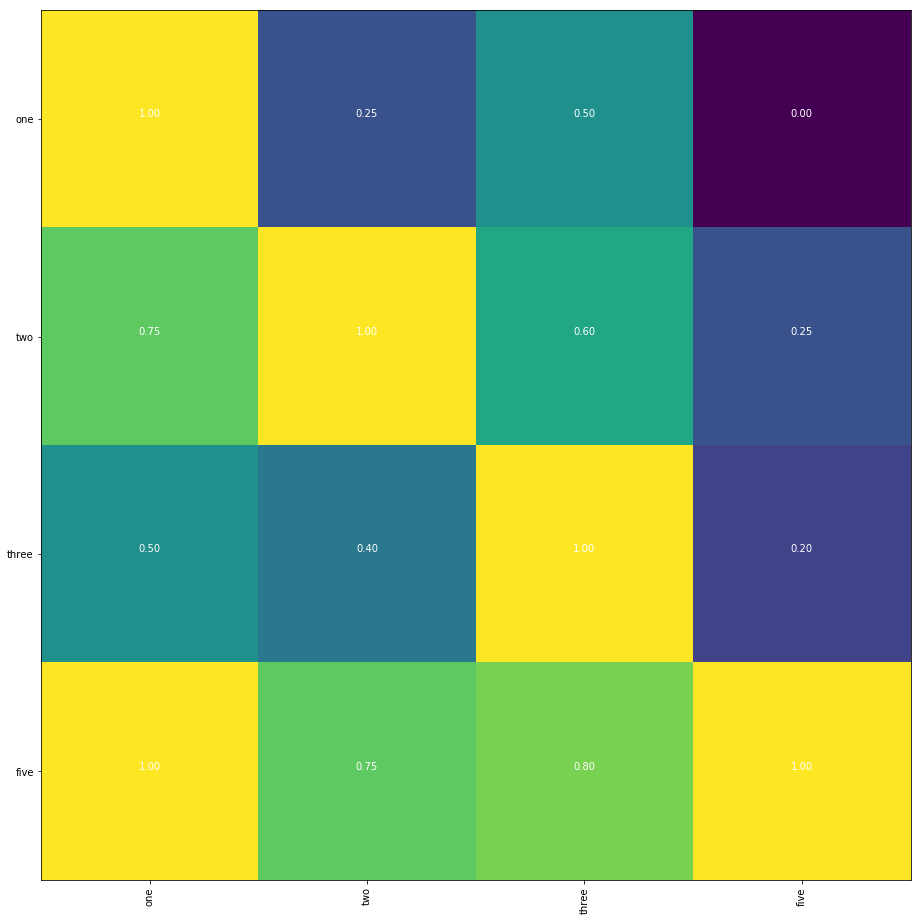

In [73]:
df = pd.DataFrame(np.random.randn(6, 3), index=['a', 'b', 'c', 'e', 'f', 'h'],
                  columns=['one', 'two', 'three'])

df['four'] = 'bar'
df['five'] = df['one'] > 0
df.loc['a', 'one'] = float('NaN')
df.loc['f', 'one'] = float('NaN')
df.loc['f', 'two'] = float('NaN')
df.loc['c', 'four'] = float('NaN')
df.loc['h', 'five'] = float('NaN')

# df.replace('NaN', -999, inplace=True)
print(df)

cat_cols = list(df.select_dtypes(include=['object']).columns)
num_cols = list(df.select_dtypes(exclude=['object']).columns)
print(num_cols)

# build 'mean(feat1 > feat2)' plot
gt_matrix(num_cols,df, 16)


In [76]:
from sklearn import datasets

iris = datasets.load_iris()
iris

{'DESCR': 'Iris Plants Database\n====================\n\nNotes\n-----\nData Set Characteristics:\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)\n    ============== ==== ==== ======= ===== ==

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[[1.0, 1.0, 1.0, 1.0], [0.0, 1.0, 0.3333333333333333, 1.0], [0.0, 0.6666666666666666, 1.0, 1.0], [0.0, 0.0, 0.0, 1.0]]


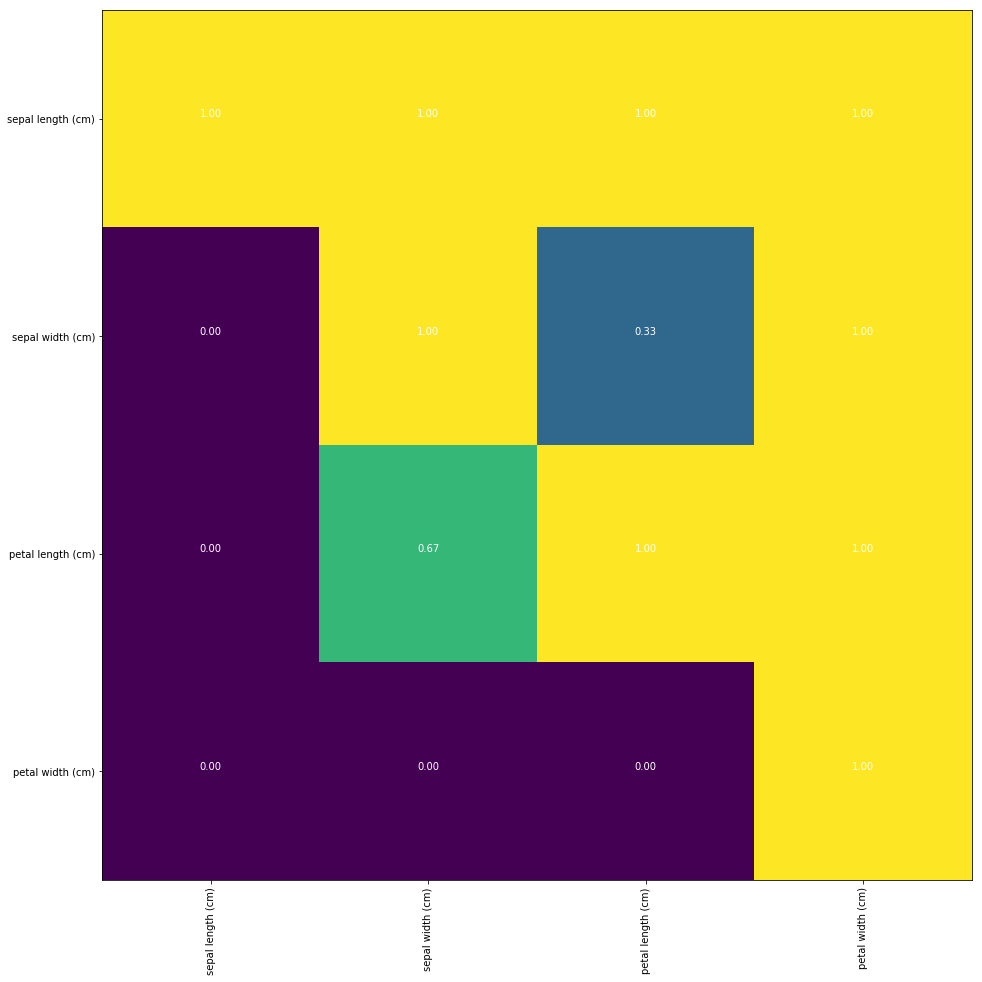

In [104]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
cat_cols = list(df.select_dtypes(include=['object']).columns)
num_cols = list(df.select_dtypes(exclude=['object']).columns)
print(num_cols)

# build 'mean(feat1 > feat2)' plot
gt_matrix(num_cols,df, 16)

**显示不同类别数据的直方图分布**

用于观察不同类的某个变量值的分布，非常不错的。

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


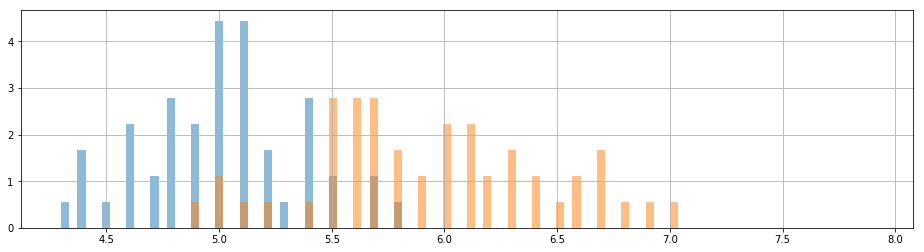

In [110]:
def hist_it1(feat, normed=True):
    plt.figure(figsize=(16,4))
    feat[Y==0].hist(bins=100,range=(feat.min(),feat.max()),normed=True,alpha=0.5)  #看上去normed好像没啥用
    feat[Y==1].hist(bins=100,range=(feat.min(),feat.max()),normed=True,alpha=0.5)
#     plt.ylim((0,1))

Y = iris.target
print(df.head())

# 下图中棕色部分显示的公共部分
hist_it1(df['sepal length (cm)'])





/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74b3636860>,
      dtype=object)

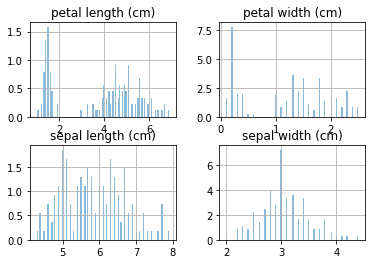

In [111]:
df.hist(bins=100,normed=True,alpha=0.5)

### 1.41  python的一些画图工具 【2018-11-15】

https://www.zhihu.com/question/39684179

Visualization tools
- [Seaborn](https://seaborn.pydata.org/) : 基于matplotlib的高级可视化效果库
- [Plotly](https://plot.ly/python/)：交互信息可视化的工具。实现了在线导入数据做可视化并保存内容在云端server的功能。
- [Bokeh](https://github.com/bokeh/bokeh)：可以是可以交互
- [ggplot](http://ggplot.yhathq.com/): 和R语言那个GGPLOT2比起来，简直是感觉在用两个包
- [Graph visualization with NetworkX](https://networkx.github.io/)：



In [11]:
~True & ~True

-2

In [13]:
~False & ~True

-2

In [12]:
~False & ~False

-1